#Fashion Mnist tf.converter()

The goal of this notebook is very clear


*   training a model using convlution neural net
*   convert the trained model to use in device based system

If you are not looking for any of the above feel free to quit.



This notebook uses the **Fashion MNIST** dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

![mnist](https://tensorflow.org/images/fashion-mnist-sprite.png)

#SetUp

In [0]:
# TensorFlow
import tensorflow as tf

# TensorFlow Datsets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper Libraries
import numpy as np
import matplotlib.pyplot as plt
import pathlib

from os import getcwd

print('\u2022 Using TensorFlow Version:', tf.__version__)
print('\u2022 GPU Device Found.' if tf.test.is_gpu_available() else '\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.2.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
• GPU Device Not Found. Running on CPU


#Download Fashion Mnist Dataset
We will use tensorflow dataset

In [0]:
splits = tfds.Split.ALL.subsplit(weighted=(80,10,10))   #define train , validation, test portion

filePath = f"/tmp2/"
splits, info = tfds.load('fashion_mnist', with_info=True, as_supervised=True, split=['train[:80%]','train[80%:90%]','train[90%:100%]'], data_dir=filePath)
(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [0]:
class_names = ['T-shirt_top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [0]:
# Create a labels.txt file with the class names
with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

In [0]:
# The images in the dataset are 28 by 28 pixels.
IMG_SIZE = 28

#Preprocessing Data

#Normalized Data


In [0]:

def format_example(image, label):
    # Cast image to float32
    image = tf.image.convert_image_dtype(
    image, dtype="float32", saturate=False, name=None)
        
    # Normalize the image in the range [0, 1]
    image = tf.image.per_image_standardization(image)
    
    return image, label

In [0]:
# Specify the batch size
BATCH_SIZE = 256

#Create Dataset from Labels And Images

In [0]:
# Create Datasets
train_batches = train_examples.cache().shuffle(num_examples//4).batch(BATCH_SIZE).map(format_example).prefetch(1)
validation_batches = validation_examples.cache().batch(BATCH_SIZE).map(format_example)
test_batches = test_examples.map(format_example).batch(1)

#Building the Model¶

Model: "sequential"
_________________________________________________________________
Layer (type)                   Output Shape              Param #   
----------------------------------------------------------------
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
flatten (Flatten)            (None, 3872)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                247872    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
---------------------------------------------------------------------
Total params: 253,322
Trainable params: 253,322
Non-trainable params: 0

In [0]:
model = tf.keras.Sequential([
    # Set the input shape to (28, 28, 1), kernel size=3, filters=16 and use ReLU activation,
    tf.keras.layers.Conv2D(16,(3,3),activation="relu",input_shape=(28,28,1)),
      
    tf.keras.layers.MaxPooling2D(),
      
    # Set the number of filters to 32, kernel size to 3 and use ReLU activation 
    tf.keras.layers.Conv2D(32,(3,3),activation="relu"),
      
    # Flatten the output layer to 1 dimension
    tf.keras.layers.Flatten(),
      
    # Add a fully connected layer with 64 hidden units and ReLU activation
    tf.keras.layers.Dense(64,activation="relu"),
      
    # Attach a final softmax classification head

    tf.keras.layers.Dense(10, activation='softmax')])

# Set the appropriate loss function and use accuracy as your metric
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
flatten (Flatten)            (None, 3872)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                247872    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 253,322
Trainable params: 253,322
Non-trainable params: 0
__________________________________________________

#Training

In [0]:
history = model.fit(train_batches, epochs=10, validation_data=validation_batches)

Epoch 1/10
188/188 [==============================] - 22s 120ms/step - loss: 0.5180 - accuracy: 0.8209 - val_loss: 0.3540 - val_accuracy: 0.8707
Epoch 2/10
188/188 [==============================] - 19s 99ms/step - loss: 0.3362 - accuracy: 0.8804 - val_loss: 0.3057 - val_accuracy: 0.8835
Epoch 3/10
188/188 [==============================] - 19s 99ms/step - loss: 0.2930 - accuracy: 0.8962 - val_loss: 0.2921 - val_accuracy: 0.8915
Epoch 4/10
188/188 [==============================] - 19s 99ms/step - loss: 0.2631 - accuracy: 0.9056 - val_loss: 0.2715 - val_accuracy: 0.9007
Epoch 5/10
188/188 [==============================] - 19s 99ms/step - loss: 0.2364 - accuracy: 0.9156 - val_loss: 0.2635 - val_accuracy: 0.9045
Epoch 6/10
188/188 [==============================] - 19s 99ms/step - loss: 0.2184 - accuracy: 0.9224 - val_loss: 0.2528 - val_accuracy: 0.9078
Epoch 7/10
188/188 [==============================] - 19s 99ms/step - loss: 0.1964 - accuracy: 0.9288 - val_loss: 0.2483 - val_accuracy

#Exporting to TFLite
You will now save the model to TFLite. We should note, that you will probably see some warning messages when running the code below. These warnings have to do with software updates and should not cause any errors or prevent your code from running.

In [0]:
# EXERCISE: Use the tf.saved_model API to save your model in the SavedModel format. 
export_dir = 'saved_model/1'

# YOUR CODE HERE
tf.saved_model.save(model, export_dir)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: saved_model/1/assets


INFO:tensorflow:Assets written to: saved_model/1/assets


In [0]:
# Select mode of optimization
mode = "Speed" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [0]:
# EXERCISE: Use the TFLiteConverter SavedModel API to initialize the converter

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

#Writing model

In [0]:
tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

258672

#Test the model with tensorflow lite interpreter

In [0]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [0]:
# Gather results for the randomly sampled test images
predictions = []
test_labels = []
test_images = []

for img, label in test_batches.take(50):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    test_labels.append(label[0])
    test_images.append(np.array(img))

#Visualization

In [0]:
# Utilities functions for plotting

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label.numpy():
        color = 'green'
    else:
        color = 'red'
        
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]),
                                         color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks(list(range(10)))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array[0], color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array[0])
    
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

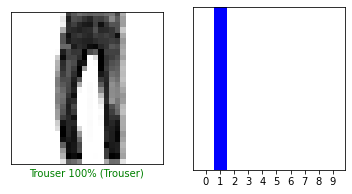

In [0]:
# Visualize the outputs

# Select index of image to display. Minimum index value is 1 and max index value is 50. 
index = 49 

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(index, predictions, test_labels)
plt.show()

#Optimize For Storage

In [0]:
# Select mode of optimization
mode = "Storage" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [0]:
# EXERCISE: Use the TFLiteConverter SavedModel API to initialize the converter

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [0]:
tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

258672

In [0]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [0]:
# Gather results for the randomly sampled test images
predictions = []
test_labels = []
test_images = []

for img, label in test_batches.take(50):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    test_labels.append(label[0])
    test_images.append(np.array(img))

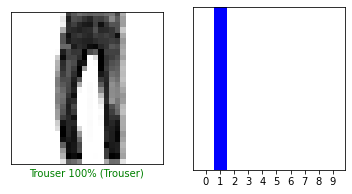

In [0]:
# Visualize the outputs

# Select index of image to display. Minimum index value is 1 and max index value is 50. 
index = 49 

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(index, predictions, test_labels)
plt.show()